# drive 마운트, seed 고정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.cluster import MiniBatchKMeans


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 데이터 로드 및 전처리

In [ ]:
train_data  = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_test.csv')

# 열 이름 변경
train_data.columns = train_data.columns.str.replace('fog_train.', '')
test_data.columns = test_data.columns.str.replace('fog_test.', '')

# 'Unnamed: 0' 열 제거
train_data.drop(columns=['Unnamed: 0'], inplace=True)
test_data.drop(columns=['Unnamed: 0'], inplace=True)

# 테스트 데이터에서 class 열 제거, 목표변수가 test데이터 열에 포함되면 안되기 때문
test_data = test_data.drop(columns=['class'], errors='ignore')

# 결측값 처리 (-99, -99.9를 NaN으로 대체)
train_data.replace([-99, -99.9], np.nan, inplace=True)
test_data.replace([-99, -99.9], np.nan, inplace=True)

In [ ]:
# hm 컬럼에서 값이 0인 경우를 1로 대체
train_data['hm'] = train_data['hm'].replace(0, 1)

# 본문

In [ ]:
# train데이터는 총 3개년의 데이터가 있는데 한 년도에 29일이 포함되어잇다.
# test데이터에는 한 년도의 데이터가 있는데 29일이 포함되어잇지 않다.


In [ ]:
train_data['year'] = train_data['year'].replace({'I': 2020, 'J': 2021, 'K': 2022})
test_data['year'] = test_data['year'].replace({'L': 2024})

In [ ]:
# 'time' 열을 'hour' 열로 변경
train_data.rename(columns={'time': 'hour'}, inplace=True)
test_data.rename(columns={'time': 'hour'}, inplace=True)

In [ ]:
# 'datetime' 열 추가
train_data['datetime'] = pd.to_datetime(train_data[['year', 'month', 'day', 'hour', 'minute']])

In [ ]:
# 'datetime' 열 추가
test_data['datetime'] = pd.to_datetime(test_data[['year', 'month', 'day', 'hour', 'minute']])

# 본문

In [ ]:
def fill_class(row):
    if pd.isna(row['class']):
        if row['vis1'] < 200:
            return 1
        elif 200 <= row['vis1'] < 500:
            return 2
        elif 500 <= row['vis1'] < 1000:
            return 3
        else:
            return 4
    else:
        return row['class']

def interpolate_and_fill(df):
    # vis1 결측치 보간
    df['vis1'] = df['vis1'].interpolate(method='time')

    # 양 끝의 결측치를 다음 값과 이전 값으로 채우기
    df['vis1'] = df['vis1'].ffill().bfill()

    # vis1 값을 바탕으로 class 결측값 대체
    df['class'] = df.apply(fill_class, axis=1)

    # vis1, class 열을 제외한 나머지 수치형 변수들에 대해 결측치 보간
    numerical_cols = df.select_dtypes(include=[np.number]).columns.difference(['vis1', 'class'])
    df[numerical_cols] = df[numerical_cols].interpolate(method='time')

    # 양 끝의 결측치를 다음 값과 이전 값으로 채우기
    df[numerical_cols] = df[numerical_cols].ffill().bfill()

    return df

In [ ]:
def interpolate_and_fill_test(df):
# vis1, class 열을 제외한 나머지 수치형 변수들에 대해 결측치 보간
    numerical_cols = df.select_dtypes(include=[np.number]).columns.difference(['vis1', 'class'])
    df[numerical_cols] = df[numerical_cols].interpolate(method='time')

    # 양 끝의 결측치를 다음 값과 이전 값으로 채우기
    df[numerical_cols] = df[numerical_cols].ffill().bfill()

    return df

In [ ]:
# test 데이터의 결측치를 보간
grouped_1 = test_data.groupby('stn_id')
interpolated_data_1 = []

for name, group in grouped_1:
    print(f"Processing region (interpolation): {name}")

    group = group.set_index('datetime')
    group = group.interpolate()  # 결측치 보간
    interpolated_data_1.append(group.reset_index())

# 보간된 데이터프레임을 다시 하나의 데이터프레임으로 합침
interpolated_test_data = pd.concat(interpolated_data_1)
interpolated_test_data

Processing region (interpolation): AI
Processing region (interpolation): BE
Processing region (interpolation): CC
Processing region (interpolation): DD
Processing region (interpolation): ED


,datetime,year,month,day,hour,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts
0,2024-01-01 00:00:00,2024,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6
1,2024-01-01 00:10:00,2024,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6
2,2024-01-01 00:20:00,2024,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7
3,2024-01-01 00:30:00,2024,1,1,0,30,AI,323.6,0.7,-2.6,0.0,88.7,0.0,-1.6
4,2024-01-01 00:40:00,2024,1,1,0,40,AI,208.4,0.2,-2.6,0.0,89.0,0.0,-1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,2024-12-31 23:10:00,2024,12,31,23,10,ED,338.8,6.1,4.5,0.0,71.3,0.0,1.9
52556,2024-12-31 23:20:00,2024,12,31,23,20,ED,335.2,5.8,4.6,0.0,71.4,0.0,1.9
52557,2024-12-31 23:30:00,2024,12,31,23,30,ED,337.1,5.3,4.5,0.0,72.1,0.0,1.8
52558,2024-12-31 23:40:00,2024,12,31,23,40,ED,322.0,3.7,4.3,0.0,72.5,0.0,1.4


In [ ]:
# 1. train결측치 보간
grouped = train_data.groupby('stn_id')
interpolated_data = []

for name, group in grouped:
    print(f"Processing region (interpolation): {name}")

    group = group.set_index('datetime')
    group = interpolate_and_fill(group)
    interpolated_data.append(group.reset_index())

# 보간된 데이터프레임을 다시 하나의 데이터프레임으로 합침
interpolated_train_data = pd.concat(interpolated_data)

Processing region (interpolation): AA
Processing region (interpolation): AB
Processing region (interpolation): AC
Processing region (interpolation): AD
Processing region (interpolation): AE
Processing region (interpolation): AF
Processing region (interpolation): AG
Processing region (interpolation): AH
Processing region (interpolation): BA
Processing region (interpolation): BB
Processing region (interpolation): BC
Processing region (interpolation): BD
Processing region (interpolation): CA
Processing region (interpolation): CB
Processing region (interpolation): DA
Processing region (interpolation): DB
Processing region (interpolation): DC
Processing region (interpolation): EA
Processing region (interpolation): EB
Processing region (interpolation): EC


# 삼각

In [ ]:
# 삼각함수를 사용한 시계열 특성 생성 함수
def create_sin_cos_features(df):
    # 시간 단위로 변환
    df['seconds_in_day'] = df['hour'] * 3600 + df['minute'] * 60
    df['seconds_in_year'] = (df['datetime'] - pd.to_datetime(df['datetime'].dt.year.astype(str) + '-01-01')).dt.total_seconds()

    # 하루를 기준으로 시간(hour, minute) 변환
    df['time_sin'] = np.sin(2 * np.pi * df['seconds_in_day'] / 86400)
    df['time_cos'] = np.cos(2 * np.pi * df['seconds_in_day'] / 86400)

    # 1년을 기준으로 시간(year, month, day) 변환
    df['yearly_time_sin'] = np.sin(2 * np.pi * df['seconds_in_year'] / (365 * 86400))
    df['yearly_time_cos'] = np.cos(2 * np.pi * df['seconds_in_year'] / (365 * 86400))

    return df


In [ ]:

# 시계열 특성 생성
interpolated_train_data_t = create_sin_cos_features(interpolated_train_data)

print("\nFinal DataFrame with Sin and Cos Features:")
print(interpolated_train_data_t[['datetime', 'time_sin', 'time_cos', 'yearly_time_sin', 'yearly_time_cos']].head())


Final DataFrame with Sin and Cos Features:
             datetime  time_sin  time_cos  yearly_time_sin  yearly_time_cos
0 2020-01-01 00:10:00  0.043619  0.999048         0.000120              1.0
1 2020-01-01 00:20:00  0.087156  0.996195         0.000239              1.0
2 2020-01-01 00:30:00  0.130526  0.991445         0.000359              1.0
3 2020-01-01 00:40:00  0.173648  0.984808         0.000478              1.0
4 2020-01-01 00:50:00  0.216440  0.976296         0.000598              1.0


In [ ]:

# 시계열 특성 생성
interpolated_test_data_t = create_sin_cos_features(interpolated_test_data)

print("\nFinal DataFrame with Sin and Cos Features:")
print(interpolated_test_data_t[['datetime', 'time_sin', 'time_cos', 'yearly_time_sin', 'yearly_time_cos']].head())


Final DataFrame with Sin and Cos Features:
             datetime  time_sin  time_cos  yearly_time_sin  yearly_time_cos
0 2024-01-01 00:00:00  0.000000  1.000000         0.000000              1.0
1 2024-01-01 00:10:00  0.043619  0.999048         0.000120              1.0
2 2024-01-01 00:20:00  0.087156  0.996195         0.000239              1.0
3 2024-01-01 00:30:00  0.130526  0.991445         0.000359              1.0
4 2024-01-01 00:40:00  0.173648  0.984808         0.000478              1.0


In [ ]:
interpolated_train_data_t.isnull().sum()

datetime           0
year               0
month              0
day                0
hour               0
minute             0
stn_id             0
ws10_deg           0
ws10_ms            0
ta                 0
re                 0
hm                 0
sun10              0
ts                 0
vis1               0
class              0
seconds_in_day     0
seconds_in_year    0
time_sin           0
time_cos           0
yearly_time_sin    0
yearly_time_cos    0
dtype: int64

In [ ]:
interpolated_test_data_t.isnull().sum()

datetime            0
year                0
month               0
day                 0
hour                0
minute              0
stn_id              0
ws10_deg            0
ws10_ms             0
ta                  0
re                  0
hm                  0
sun10               0
ts                 54
seconds_in_day      0
seconds_in_year     0
time_sin            0
time_cos            0
yearly_time_sin     0
yearly_time_cos     0
dtype: int64

# 풍향(이제는 더미가된...)

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 각도 범위를 4개 방향으로 나누는 함수
def degree_to_direction(deg):
    if (337.5 <= deg <= 360) or (0 <= deg < 45) or (315 <= deg < 337.5):
        return 'N'
    elif 45 <= deg < 135:
        return 'E'
    elif 135 <= deg < 225:
        return 'S'
    elif 225 <= deg < 315:
        return 'W'
    else:
        return 'Unknown'

In [ ]:

# 각도 데이터를 방향으로 변환하기 전에 float으로 변환
interpolated_train_data_t['ws10_deg'] = interpolated_train_data_t['ws10_deg'].astype(float)


# 각도 데이터를 방향으로 변환
interpolated_train_data_t['ws10_deg'] = interpolated_train_data_t['ws10_deg'].apply(degree_to_direction)

In [ ]:

# 각도 데이터를 방향으로 변환하기 전에 float으로 변환
interpolated_test_data_t['ws10_deg'] = interpolated_test_data_t['ws10_deg'].astype(float)


# 각도 데이터를 방향으로 변환
interpolated_test_data_t['ws10_deg'] = interpolated_test_data_t['ws10_deg'].apply(degree_to_direction)

In [ ]:
interpolated_train_data_t

,datetime,year,month,day,hour,minute,stn_id,ws10_deg,ws10_ms,ta,...,sun10,ts,vis1,class,seconds_in_day,seconds_in_year,time_sin,time_cos,yearly_time_sin,yearly_time_cos
0,2020-01-01 00:10:00,2020,1,1,0,10,AA,N,0.0,-6.4,...,0.0,-2.8,20000.0,4.0,600,600.0,0.043619,0.999048,0.000120,1.0
1,2020-01-01 00:20:00,2020,1,1,0,20,AA,N,0.0,-6.3,...,0.0,-2.7,20000.0,4.0,1200,1200.0,0.087156,0.996195,0.000239,1.0
2,2020-01-01 00:30:00,2020,1,1,0,30,AA,N,0.0,-6.3,...,0.0,-2.6,20000.0,4.0,1800,1800.0,0.130526,0.991445,0.000359,1.0
3,2020-01-01 00:40:00,2020,1,1,0,40,AA,N,0.4,-6.2,...,0.0,-2.6,20000.0,4.0,2400,2400.0,0.173648,0.984808,0.000478,1.0
4,2020-01-01 00:50:00,2020,1,1,0,50,AA,E,0.5,-6.1,...,0.0,-2.5,20000.0,4.0,3000,3000.0,0.216440,0.976296,0.000598,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157817,2022-12-31 23:10:00,2022,12,31,23,10,EC,W,7.7,2.5,...,0.0,-0.9,20000.0,4.0,83400,31533000.0,-0.216440,0.976296,-0.000598,1.0
157818,2022-12-31 23:20:00,2022,12,31,23,20,EC,W,5.7,2.3,...,0.0,-1.3,20000.0,4.0,84000,31533600.0,-0.173648,0.984808,-0.000478,1.0
157819,2022-12-31 23:30:00,2022,12,31,23,30,EC,W,4.9,2.2,...,0.0,-1.4,20000.0,4.0,84600,31534200.0,-0.130526,0.991445,-0.000359,1.0
157820,2022-12-31 23:40:00,2022,12,31,23,40,EC,W,4.6,2.1,...,0.0,-1.6,20000.0,4.0,85200,31534800.0,-0.087156,0.996195,-0.000239,1.0


In [ ]:

# 시간대를 나누는 함수 정의
def assign_time_period(hour):
    if 0 <= hour <= 8:
        return 1  # High Frequency
    else:
        return 0  # Low Frequency



In [ ]:
interpolated_train_data_t['time_period'] = interpolated_train_data_t['hour'].apply(assign_time_period)

In [ ]:
interpolated_train_data_t

,datetime,year,month,day,hour,minute,stn_id,ws10_deg,ws10_ms,ta,...,ts,vis1,class,seconds_in_day,seconds_in_year,time_sin,time_cos,yearly_time_sin,yearly_time_cos,time_period
0,2020-01-01 00:10:00,2020,1,1,0,10,AA,N,0.0,-6.4,...,-2.8,20000.0,4.0,600,600.0,0.043619,0.999048,0.000120,1.0,1
1,2020-01-01 00:20:00,2020,1,1,0,20,AA,N,0.0,-6.3,...,-2.7,20000.0,4.0,1200,1200.0,0.087156,0.996195,0.000239,1.0,1
2,2020-01-01 00:30:00,2020,1,1,0,30,AA,N,0.0,-6.3,...,-2.6,20000.0,4.0,1800,1800.0,0.130526,0.991445,0.000359,1.0,1
3,2020-01-01 00:40:00,2020,1,1,0,40,AA,N,0.4,-6.2,...,-2.6,20000.0,4.0,2400,2400.0,0.173648,0.984808,0.000478,1.0,1
4,2020-01-01 00:50:00,2020,1,1,0,50,AA,E,0.5,-6.1,...,-2.5,20000.0,4.0,3000,3000.0,0.216440,0.976296,0.000598,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157817,2022-12-31 23:10:00,2022,12,31,23,10,EC,W,7.7,2.5,...,-0.9,20000.0,4.0,83400,31533000.0,-0.216440,0.976296,-0.000598,1.0,0
157818,2022-12-31 23:20:00,2022,12,31,23,20,EC,W,5.7,2.3,...,-1.3,20000.0,4.0,84000,31533600.0,-0.173648,0.984808,-0.000478,1.0,0
157819,2022-12-31 23:30:00,2022,12,31,23,30,EC,W,4.9,2.2,...,-1.4,20000.0,4.0,84600,31534200.0,-0.130526,0.991445,-0.000359,1.0,0
157820,2022-12-31 23:40:00,2022,12,31,23,40,EC,W,4.6,2.1,...,-1.6,20000.0,4.0,85200,31534800.0,-0.087156,0.996195,-0.000239,1.0,0


In [ ]:
interpolated_test_data_t['time_period'] = interpolated_test_data_t['hour'].apply(assign_time_period)

# 파생변수

In [ ]:
interpolated_train_data_t['Temp_Diff'] = interpolated_train_data_t['ta'] - interpolated_train_data_t['ts']
interpolated_test_data_t['Temp_Diff'] = interpolated_test_data_t['ta'] - interpolated_test_data_t['ts']

In [ ]:
#interpolated_train_data_t['Fog_Likelihood_Index'] = (interpolated_train_data_t['Temp_Diff'] * interpolated_train_data_t['hm']) / (interpolated_train_data_t['ws10_ms'] + 1)
#interpolated_test_data_t['Fog_Likelihood_Index'] = (interpolated_test_data_t['Temp_Diff'] * interpolated_test_data_t['hm']) / (interpolated_test_data_t['ws10_ms'] + 1)

In [ ]:
import pandas as pd
import numpy as np

# 매그너스 공식의 상수
a = 17.62
b = 243.12

# 이슬점 계산 함수
def calculate_dew_point(temperature, humidity):
    gamma = (a * temperature) / (b + temperature) + np.log(humidity / 100.0)
    dew_point = (b * gamma) / (a - gamma)
    return dew_point


In [ ]:
# 이슬점 온도 계산 및 컬럼 추가
interpolated_train_data_t['dew_point'] = interpolated_train_data_t.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

In [ ]:
interpolated_test_data_t['dew_point'] = interpolated_test_data_t.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

In [ ]:
interpolated_train_data_t['dew_point_minus_ta'] = -(interpolated_train_data_t['dew_point'] - interpolated_train_data_t['ta']).round(1)

In [ ]:
interpolated_test_data_t['dew_point_minus_ta'] = -(interpolated_test_data_t['dew_point'] - interpolated_test_data_t['ta']).round(1)

In [ ]:
interpolated_train_data_t['sqrt_rounded_diff'] = np.sqrt(interpolated_train_data_t['dew_point_minus_ta'])

In [ ]:
interpolated_test_data_t['sqrt_rounded_diff'] = np.sqrt(interpolated_test_data_t['dew_point_minus_ta'])

# 시계

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import xgboost as xgb

# 시계열 특성 생성 함수 정의
def create_time_series_features(df):
    # 이동 평균
    df['sqrt_rounded_diff_rolling_mean_30m'] = df['sqrt_rounded_diff'].rolling(window=3, min_periods=1).mean()  # 30분 이동 평균 (10분 간격 데이터)
    df['sqrt_rounded_diff_rolling_mean_1h'] = df['sqrt_rounded_diff'].rolling(window=6, min_periods=1).mean()   # 1시간 이동 평균 (10분 간격 데이터)
    df['sqrt_rounded_diff_rolling_mean_3h'] = df['sqrt_rounded_diff'].rolling(window=18, min_periods=1).mean()  # 3시간 이동 평균 (10분 간격 데이터)

    # 이동 표준편차
    df['sqrt_rounded_diff_rolling_std_30m'] = df['sqrt_rounded_diff'].rolling(window=3, min_periods=1).std()    # 30분 이동 표준편차
    df['sqrt_rounded_diff_rolling_std_1h'] = df['sqrt_rounded_diff'].rolling(window=6, min_periods=1).std()     # 1시간 이동 표준편차
    df['sqrt_rounded_diff_rolling_std_3h'] = df['sqrt_rounded_diff'].rolling(window=18, min_periods=1).std()    # 3시간 이동 표준편차

    # 시간 지연 변수
    df['sqrt_rounded_diff_lag_1'] = df['sqrt_rounded_diff'].shift(1)  # 10분 이전 값
    df['sqrt_rounded_diff_lag_3'] = df['sqrt_rounded_diff'].shift(3)  # 30분 이전 값
    df['sqrt_rounded_diff_lag_6'] = df['sqrt_rounded_diff'].shift(6)  # 1시간 이전 값
    df['sqrt_rounded_diff_lag_18'] = df['sqrt_rounded_diff'].shift(18)  # 3시간 이전 값

    return df



In [ ]:
# 데이터프레임 생성 (기존 데이터프레임을 사용하여 새로운 데이터프레임 생성)
train_data = interpolated_train_data_t.copy()
test_data = interpolated_test_data_t.copy()  # 테스트 데이터의 예시

# 지역별로 시계열 특성 생성 및 결측치 처리
train_data_list = []
test_data_list = []

for region in train_data['stn_id'].unique():
    # 훈련 데이터에 시계열 특성 생성
    train_region_data = train_data[train_data['stn_id'] == region].copy()
    train_region_data = create_time_series_features(train_region_data)
    train_region_data = train_region_data.dropna()  # 결측치 제거
    train_data_list.append(train_region_data)

for region in test_data['stn_id'].unique():
    # 테스트 데이터에 시계열 특성 생성
    test_region_data = test_data[test_data['stn_id'] == region].copy()
    test_region_data = create_time_series_features(test_region_data)
    test_region_data = test_region_data.fillna(method='bfill').fillna(method='ffill')  # 결측치 보간
    test_data_list.append(test_region_data)


In [ ]:
# 리스트를 데이터프레임으로 결합
train_data_final = pd.concat(train_data_list)
test_data_final = pd.concat(test_data_list)

# 축약

In [ ]:
###
###
### 이상치제거 feature 만들

In [ ]:
# 필요 없는 열 제거
columns_to_drop = ['datetime', 'month', 'day', 'hour', 'minute', 'seconds_in_day', 'seconds_in_year','dew_point_minus_ta', 'dew_point','ts']

train_data_final_drop = train_data_final.drop(columns=columns_to_drop)
# 필요 없는 열 제거
test_data_final_drop = test_data_final.drop(columns=columns_to_drop)

In [ ]:
train_data_final_drop.shape

(3156099, 26)

In [ ]:
test_data_final_drop.shape

(262800, 24)

In [ ]:
import pandas as pd

# 검증용 데이터로 사용할 (year, 지역) 목록
val_regions = [
    ('AA', 2020),
    ('EC', 2021),
    ('DA', 2022),
    ('BB', 2022),
    ('CA', 2022),
    ('AB', 2021),
    ('AD', 2022),
    ('BA', 2020),
    ('DB', 2021)
]

# year와 지역 조건에 맞는 데이터 필터링
conditions = [(train_data_final_drop['stn_id'] == stn_id) & (train_data_final_drop['year'] == year) for stn_id, year in val_regions]
val_condition = conditions[0]
for condition in conditions[1:]:
    val_condition |= condition

train_df_A3_val = train_data_final_drop[val_condition]
train_df_A3_train = train_data_final_drop[~val_condition]


In [ ]:
train_df_A3_val

,year,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,vis1,class,...,sqrt_rounded_diff_rolling_mean_30m,sqrt_rounded_diff_rolling_mean_1h,sqrt_rounded_diff_rolling_mean_3h,sqrt_rounded_diff_rolling_std_30m,sqrt_rounded_diff_rolling_std_1h,sqrt_rounded_diff_rolling_std_3h,sqrt_rounded_diff_lag_1,sqrt_rounded_diff_lag_3,sqrt_rounded_diff_lag_6,sqrt_rounded_diff_lag_18
18,2020,AA,40.8,0.0,-5.6,0.0,46.3,0.0,19165.0,4.0,...,3.135778,3.167288,3.296522,0.018443,0.044102,0.106548,3.146427,3.162278,3.286335,3.420526
19,2020,AA,0.0,0.0,-5.6,0.0,46.0,0.0,20000.0,4.0,...,3.130468,3.148975,3.277188,0.015972,0.027296,0.103102,3.114482,3.146427,3.240370,3.478505
20,2020,AA,0.0,0.0,-5.5,0.0,47.0,0.0,20000.0,4.0,...,3.114455,3.133082,3.261743,0.016054,0.023516,0.108070,3.130495,3.146427,3.193744,3.376389
21,2020,AA,0.0,0.0,-5.4,0.0,48.5,0.0,20000.0,4.0,...,3.087344,3.111561,3.241036,0.049603,0.042708,0.114355,3.098387,3.114482,3.162278,3.405877
22,2020,AA,0.0,0.0,-5.5,0.0,46.5,0.0,20000.0,4.0,...,3.082006,3.106237,3.225665,0.043069,0.039352,0.111549,3.033150,3.130495,3.146427,3.391165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105257,2021,EC,312.8,7.1,-2.3,0.0,47.4,0.0,20000.0,4.0,...,3.082122,3.071307,3.103581,0.028025,0.022140,0.034458,3.065942,3.049590,3.082207,3.209361
105258,2021,EC,315.3,7.2,-2.3,0.0,46.3,0.0,20000.0,4.0,...,3.114234,3.087363,3.102704,0.048168,0.042781,0.032603,3.114482,3.065942,3.065942,3.178050
105259,2021,EC,315.6,7.2,-2.3,0.0,45.5,0.0,20000.0,4.0,...,3.156835,3.108663,3.106218,0.039910,0.058800,0.038627,3.162278,3.065942,3.065942,3.130495
105260,2021,EC,312.3,7.2,-2.3,0.0,44.6,0.0,20000.0,4.0,...,3.198797,3.140460,3.112322,0.039291,0.070821,0.049765,3.193744,3.114482,3.049590,3.130495


# 풍향에 관한 설명

In [ ]:
#N (북) : 348.75° ~ 11.25°
#NNE (북북동) : 11.25° ~ 33.75°
#NE (북동) : 33.75° ~ 56.25°
#ENE (동북동) : 56.25° ~ 78.75°
#E (동) : 78.75° ~ 101.25°
#ESE (동남동) : 101.25° ~ 123.75°
#SE (남동) : 123.75° ~ 146.25°
#SSE (남남동) : 146.25° ~ 168.75°
#S (남) : 168.75° ~ 191.25°
#SSW (남남서) : 191.25° ~ 213.75°
#SW (남서) : 213.75° ~ 236.25°
#WSW (서남서) : 236.25° ~ 258.75°
#W (서) : 258.75° ~ 281.25°
#WNW (서북서) : 281.25° ~ 303.75°
#NW (북서) : 303.75° ~ 326.25°
#NNW (북북서) : 326.25° ~ 348.75°

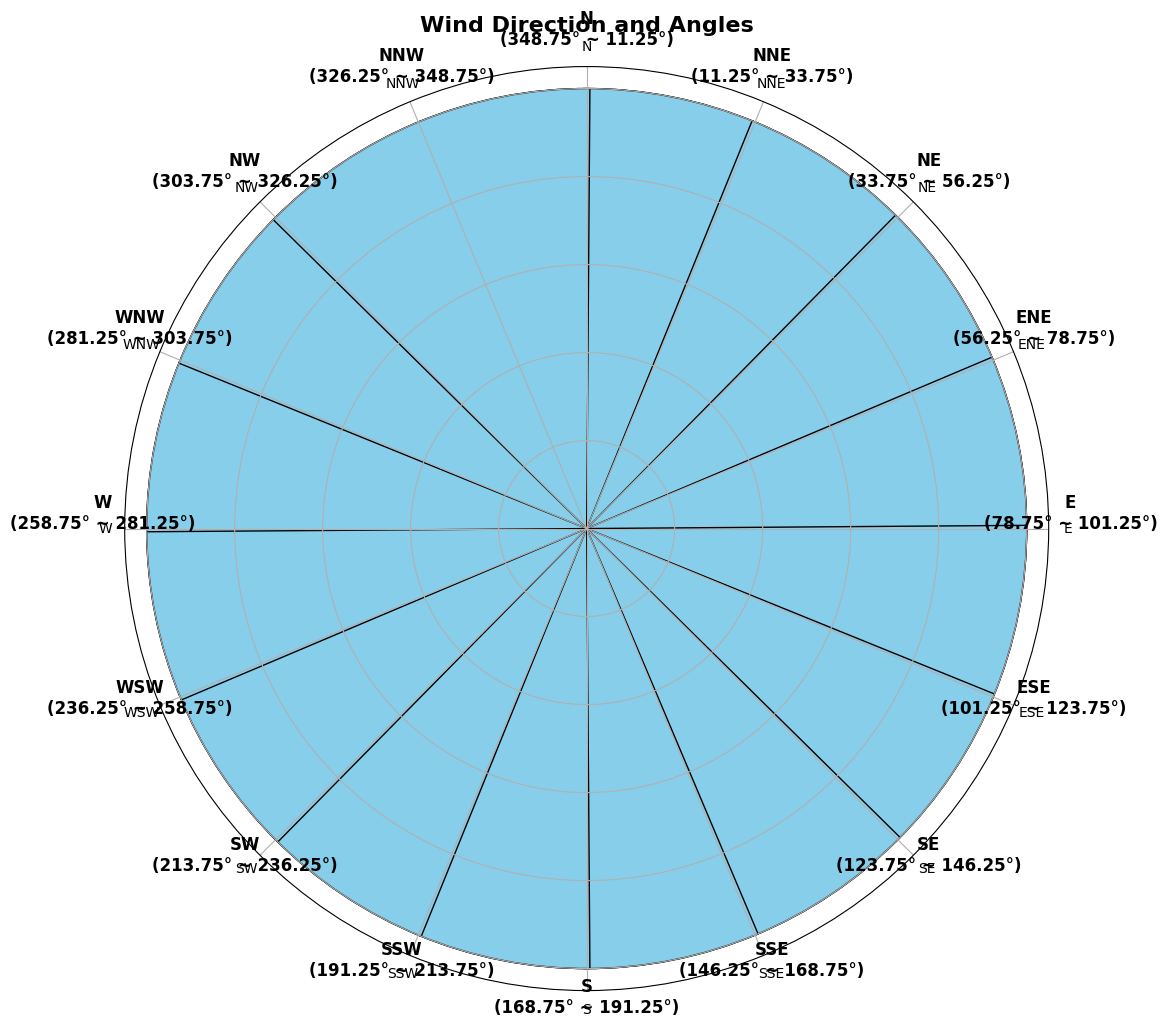

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 방향과 각도 범위 정의
directions = [
    'N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
    'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'
]
angle_ranges = [
    '348.75° ~ 11.25°', '11.25° ~ 33.75°', '33.75° ~ 56.25°', '56.25° ~ 78.75°',
    '78.75° ~ 101.25°', '101.25° ~ 123.75°', '123.75° ~ 146.25°', '146.25° ~ 168.75°',
    '168.75° ~ 191.25°', '191.25° ~ 213.75°', '213.75° ~ 236.25°', '236.25° ~ 258.75°',
    '258.75° ~ 281.25°', '281.25° ~ 303.75°', '303.75° ~ 326.25°', '326.25° ~ 348.75°'
]
angles = [
    0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5,
    180, 202.5, 225, 247.5, 270, 292.5, 315, 337.5
]

# 시각화
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))
theta = np.radians(angles)  # 각도를 라디안으로 변환
radii = [1] * len(directions)  # 모든 방향의 반지름은 동일하게 설정

bars = ax.bar(theta, radii, color='skyblue', align='center', edgecolor='black')

# 각도에 따라 레이블 추가
for angle, direction, angle_range in zip(theta, directions, angle_ranges):
    ax.text(angle, 1.1, f"{direction}\n({angle_range})", horizontalalignment='center', size=12, weight='bold')

ax.set_yticklabels([])
ax.set_xticks(theta)
ax.set_xticklabels(directions)

# 북쪽이 위를 가리키도록 설정 및 시계방향 설정
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

plt.title('Wind Direction and Angles', size=16, weight='bold')
plt.show()


### Station ID A
주요 풍향: W (9.83%), WNW (9.36%), NE (8.21%)
특징: 이 스테이션은 서쪽(W)과 서북서(WNW) 방향의 바람이 가장 많이 분포되어 있으며, 북동(NE) 방향의 바람도 상대적으로 많이 나타납니다.

### Station ID B
주요 풍향: W (17.74%), WNW (13.43%), WSW (8.36%)
특징: 서쪽(W)과 서북서(WNW) 방향의 바람이 전체의 상당 부분을 차지하고 있습니다. 이 스테이션은 서쪽 계열의 바람이 지배적입니다.

### Station ID C
주요 풍향: SW (24.42%), WSW (17.88%), NE (6.58%)
특징: 남서(SW)와 서남서(WSW) 방향의 바람이 압도적으로 많습니다. 북동(NE) 방향도 다른 방향에 비해 조금 높은 비율을 보입니다.

### Station ID D
주요 풍향: N (9.84%), NNW (8.75%), NNE (8.16%)
특징: 북쪽(N) 방향의 바람이 가장 많이 나타나며, 북북서(NNW)와 북북동(NNE) 방향도 상당히 높은 비율을 차지하고 있습니다. 전반적으로 북쪽 계열의 바람이 주를 이룹니다.

### Station ID E
주요 풍향: NE (12.53%), ENE (11.30%), N (8.11%)
특징: 북동(NE)과 동북동(ENE) 방향의 바람이 많이 나타납니다. 북(N) 방향도 상당한 비율을 차지합니다. 북동 계열의 바람이 주로 분포합니다.

In [ ]:
 '''
 Station ID A:
  E: 3.63%
  ENE: 5.03%
  ESE: 5.84%
  N: 5.54%
  NE: 8.21%
  NNE: 6.34%
  NNW: 5.72%
  NW: 7.23%
  S: 3.88%
  SE: 6.05%
  SSE: 3.77%
  SSW: 4.97%
  SW: 6.62%
  W: 9.83%
  WNW: 9.36%
  WSW: 7.99%

W (9.83%), WNW (9.36%)가 많긴함.

Station ID B:
  E: 7.62%
  ENE: 5.33%
  ESE: 7.34%
  N: 6.88%
  NE: 3.39%
  NNE: 2.67%
  NNW: 3.32%
  NW: 7.71%
  S: 1.78%
  SE: 6.70%
  SSE: 3.91%
  SSW: 1.46%
  SW: 2.34%
  W: 17.74%
  WNW: 13.43%
  WSW: 8.36%

#WSW (서남서)
#W (서)
#WNW (서북서)  << 데이터 개수가 2위로 많은데도 압도적으로 위 방향이 많음!


Station ID C:
  E: 3.92%
  ENE: 3.74%
  ESE: 1.99%
  N: 4.70%
  NE: 6.58%
  NNE: 5.43%
  NNW: 2.73%
  NW: 5.25%
  S: 2.25%
  SE: 1.28%
  SSE: 1.32%
  SSW: 6.25%
  SW: 24.42%
  W: 7.51%
  WNW: 4.76%
  WSW: 17.88%

#SW (남서)
#WSW (서남서)  압도적 < C개수각 적어서 반영이 많이된거일듯


Station ID D:
  E: 4.03%
  ENE: 4.86%
  ESE: 3.18%
  N: 9.84%
  NE: 6.66%
  NNE: 8.16%
  NNW: 8.75%
  NW: 7.46%
  S: 6.37%
  SE: 6.41%
  SSE: 5.45%
  SSW: 6.02%
  SW: 6.12%
  W: 5.18%
  WNW: 6.24%
  WSW: 5.28%

# 북쪽이 많은편


Station ID E:
  E: 5.66%
  ENE: 11.30%
  ESE: 4.79%
  N: 8.11%
  NE: 12.53%
  NNE: 4.75%
  NNW: 3.64%
  NW: 7.74%
  S: 4.51%
  SE: 2.50%
  SSE: 2.42%
  SSW: 7.15%
  SW: 6.53%
  W: 6.29%
  WNW: 6.02%
  WSW: 6.04%


 #   NE (12.53%), ENE (11.30%), N (8.11%) 특징: 북동(NE)과 동북동(ENE) 방향의 바람많음
  '''

### ... 지역을 예측하는데 풍향의 영향이 컸다고 생각할수있다! 지역별로 안개 발생량은?
### B가 가장 많다! 데이터의 개수가 2위로 많은데도 많은거면... 지역별로 안개 발생량이 다르다 특히 B는
#과연이걸로 지역예측을//..

'\nStation ID A:\n E: 3.63%\n ENE: 5.03%\n ESE: 5.84%\n N: 5.54%\n NE: 8.21%\n NNE: 6.34%\n NNW: 5.72%\n NW: 7.23%\n S: 3.88%\n SE: 6.05%\n SSE: 3.77%\n SSW: 4.97%\n SW: 6.62%\n W: 9.83%\n WNW: 9.36%\n WSW: 7.99%\n\nW (9.83%), WNW (9.36%)가 많긴함. \n\nStation ID B:\n E: 7.62%\n ENE: 5.33%\n ESE: 7.34%\n N: 6.88%\n NE: 3.39%\n NNE: 2.67%\n NNW: 3.32%\n NW: 7.71%\n S: 1.78%\n SE: 6.70%\n SSE: 3.91%\n SSW: 1.46%\n SW: 2.34%\n W: 17.74%\n WNW: 13.43%\n WSW: 8.36%\n\n#WSW (서남서)\n#W (서) \n#WNW (서북서)  << 데이터 개수가 2위로 많은데 압도적으로 위 방향이 많음!\n\n\nStation ID C:\n E: 3.92%\n ENE: 3.74%\n ESE: 1.99%\n N: 4.70%\n NE: 6.58%\n NNE: 5.43%\n NNW: 2.73%\n NW: 5.25%\n S: 2.25%\n SE: 1.28%\n SSE: 1.32%\n SSW: 6.25%\n SW: 24.42%\n W: 7.51%\n WNW: 4.76%\n WSW: 17.88%\n\n#SW (남서)\n#WSW (서남서)  압도적 < C개수각 적어서 반영이 많이된거일듯\n\n\nStation ID D:\n E: 4.03%\n ENE: 4.86%\n ESE: 3.18%\n N: 9.84%\n NE: 6.66%\n NNE: 8.16%\n NNW: 8.75%\n NW: 7.46%\n S: 6.37%\n SE: 6.41%\n SSE: 5.45%\n SSW: 6.02%\n SW: 6.12%\n W: 5.18%\n WNW: 6.24

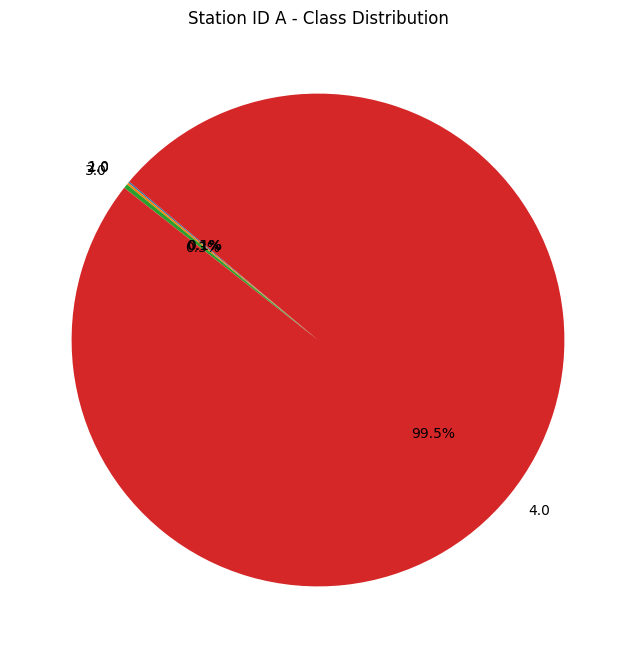

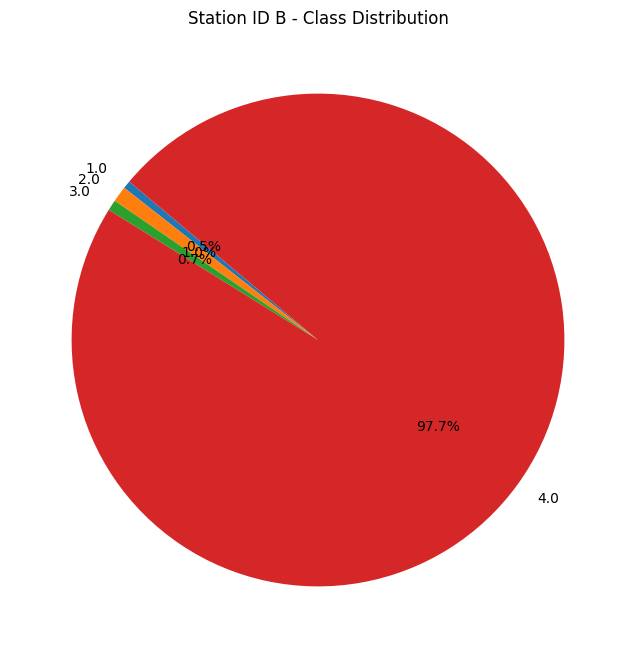

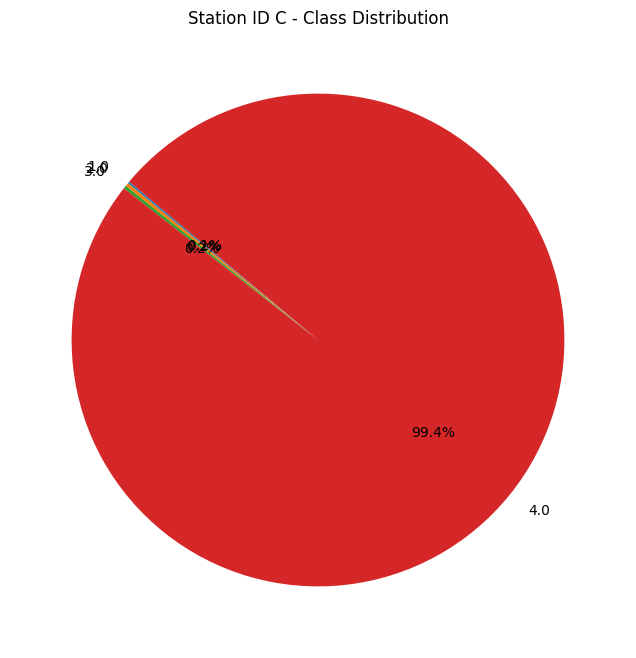

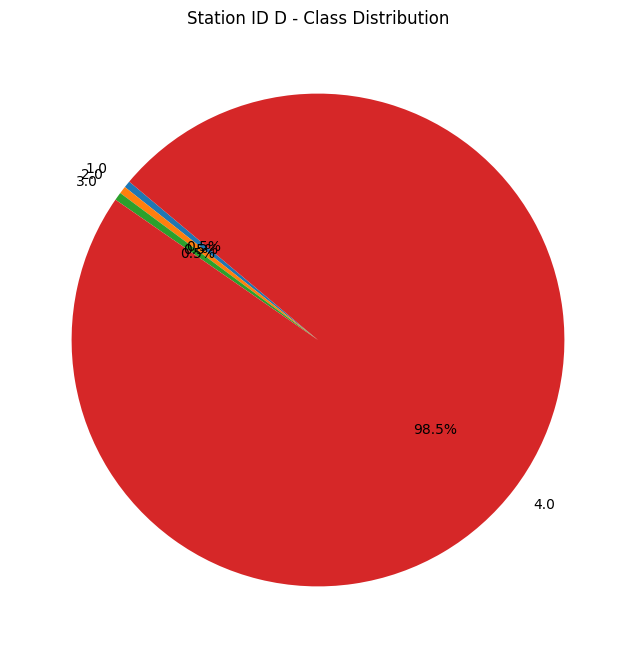

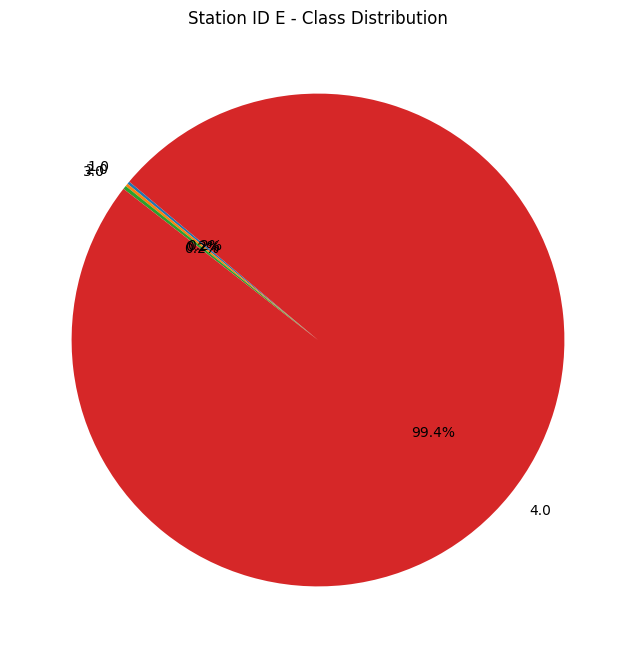

In [ ]:
# stn_id별로 class의 개수를 계산
class_counts_by_stn_id = train_data.groupby('stn_id')['class'].value_counts().unstack(fill_value=0)

# 각 stn_id별로 파이차트 그리기
for stn_id in class_counts_by_stn_id.index:
    plt.figure(figsize=(8, 8))
    class_counts_by_stn_id.loc[stn_id].plot(kind='pie', autopct='%1.1f%%', startangle=140)
    plt.title(f'Station ID {stn_id} - Class Distribution')
    plt.ylabel('')  # y축 라벨 제거
    plt.show()

In [ ]:
# stn_id별 비율 계산
direction_distribution_percentage = direction_distribution.div(direction_distribution.sum(axis=1), axis=0) * 100

# stn_id별로 비율이 높은 방향 순서대로 정렬
sorted_direction_distribution_percentage = direction_distribution_percentage.apply(lambda x: x.sort_values(ascending=False), axis=1)

# 정렬된 결과 출력
for stn_id in sorted_direction_distribution_percentage.index:
    print(f"Station ID {stn_id}:")
    sorted_percentages = sorted_direction_distribution_percentage.loc[stn_id]
    for direction, percentage in sorted_percentages.items():
        print(f"  {direction}: {percentage:.2f}%")


In [ ]:
# stn_id별 비율 계산
direction_distribution_percentage = direction_distribution.div(direction_distribution.sum(axis=1), axis=0) * 100

# stn_id별로 비율이 높은 방향 순서대로 정렬
sorted_direction_distribution_percentage = direction_distribution_percentage.apply(lambda x: x.sort_values(ascending=False), axis=1)

# 정렬된 결과 출력
for stn_id in sorted_direction_distribution_percentage.index:
    print(f"Station ID {stn_id}:")
    sorted_percentages = sorted_direction_distribution_percentage.loc[stn_id]
    for direction, percentage in sorted_percentages.items():
        print(f"  {direction}: {percentage:.2f}%")


Station ID A:
  E: 3.63%
  ENE: 5.03%
  ESE: 5.84%
  N: 5.54%
  NE: 8.21%
  NNE: 6.34%
  NNW: 5.72%
  NW: 7.23%
  S: 3.88%
  SE: 6.05%
  SSE: 3.77%
  SSW: 4.97%
  SW: 6.62%
  W: 9.83%
  WNW: 9.36%
  WSW: 7.99%
Station ID B:
  E: 7.62%
  ENE: 5.33%
  ESE: 7.34%
  N: 6.88%
  NE: 3.39%
  NNE: 2.67%
  NNW: 3.32%
  NW: 7.71%
  S: 1.78%
  SE: 6.70%
  SSE: 3.91%
  SSW: 1.46%
  SW: 2.34%
  W: 17.74%
  WNW: 13.43%
  WSW: 8.36%
Station ID C:
  E: 3.92%
  ENE: 3.74%
  ESE: 1.99%
  N: 4.70%
  NE: 6.58%
  NNE: 5.43%
  NNW: 2.73%
  NW: 5.25%
  S: 2.25%
  SE: 1.28%
  SSE: 1.32%
  SSW: 6.25%
  SW: 24.42%
  W: 7.51%
  WNW: 4.76%
  WSW: 17.88%
Station ID D:
  E: 4.03%
  ENE: 4.86%
  ESE: 3.18%
  N: 9.84%
  NE: 6.66%
  NNE: 8.16%
  NNW: 8.75%
  NW: 7.46%
  S: 6.37%
  SE: 6.41%
  SSE: 5.45%
  SSW: 6.02%
  SW: 6.12%
  W: 5.18%
  WNW: 6.24%
  WSW: 5.28%
Station ID E:
  E: 5.66%
  ENE: 11.30%
  ESE: 4.79%
  N: 8.11%
  NE: 12.53%
  NNE: 4.75%
  NNW: 3.64%
  NW: 7.74%
  S: 4.51%
  SE: 2.50%
  SSE: 2.42%
  SSW:

# 풍향끝

In [ ]:
interpolated_train_data_t_drop

In [ ]:
train_data['sun10'].corr(train_data['ts'])

0.5506797648988246

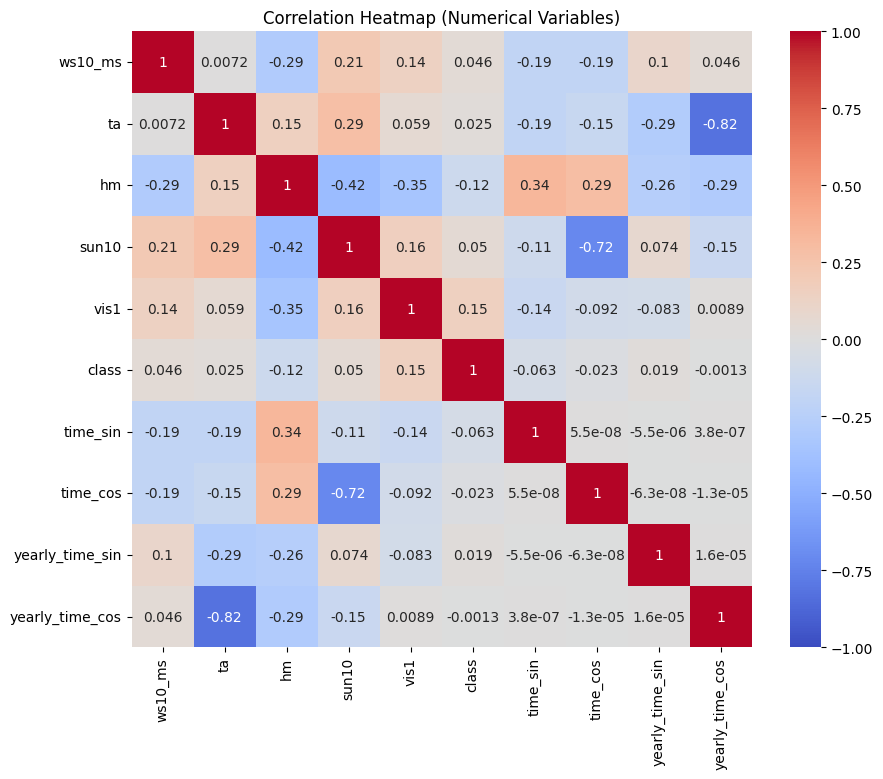

In [ ]:
import seaborn as sns

# 모든 변수 간 상관관계 계산
correlation_matrix = interpolated_train_data_t_drop.select_dtypes(include=[float, int]).corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Numerical Variables)')
plt.show()

In [ ]:
 train_data.isnull().sum()
 # 각각의 class

month                0
day                  0
time                 0
minute               0
stn_id               0
ws10_deg          5910
ws10_ms           5826
ta                3867
hm                3616
sun10            43910
ts               88639
vis1             22516
class            22516
ws10_deg_E           0
ws10_deg_ENE         0
ws10_deg_ESE         0
ws10_deg_N           0
ws10_deg_NE          0
ws10_deg_NNE         0
ws10_deg_NNW         0
ws10_deg_NW          0
ws10_deg_S           0
ws10_deg_SE          0
ws10_deg_SSE         0
ws10_deg_SSW         0
ws10_deg_SW          0
ws10_deg_W           0
ws10_deg_WNW         0
ws10_deg_WSW         0
ws10_deg_None        0
dtype: int64

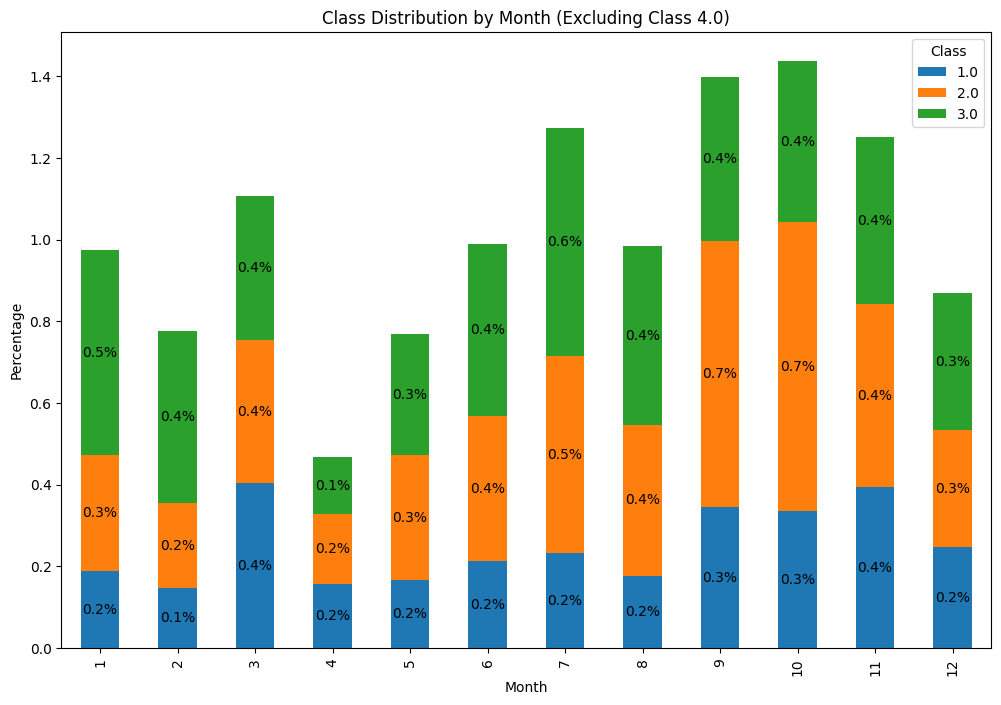

In [ ]:

# month별 class의 개수 계산
class_counts_by_month = train_data.groupby(['month', 'class']).size().unstack(fill_value=0)

# month별 비율 계산
class_percentage_by_month = class_counts_by_month.div(class_counts_by_month.sum(axis=1), axis=0) * 100

# Class 4.0 제외
class_percentage_by_month_excluding_class_4 = class_percentage_by_month.drop(columns=[4.0], errors='ignore')

# 막대 그래프 그리기
ax = class_percentage_by_month_excluding_class_4.plot(kind='bar', stacked=True, figsize=(12, 8))

# 비율을 숫자로 출력
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # 비율이 0이 아닌 경우에만 표시
        ax.text(x + width / 2, y + height / 2, f'{height:.1f}%', ha='center', va='center')

plt.xlabel('Month')
plt.ylabel('Percentage')
plt.title('Class Distribution by Month (Excluding Class 4.0)')
plt.legend(title='Class')
plt.show()

In [ ]:
# 시계열?!.. 당연한거긴 한데

In [ ]:
train_data

,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,hm,sun10,ts,vis1,class,direction
0,1,1,0,10,A,0.0,0.0,-6.4,38.9,0.0,-2.8,20000.0,4.0,N
1,1,1,0,20,A,0.0,0.0,-6.3,37.9,0.0,-2.7,20000.0,4.0,N
2,1,1,0,30,A,0.0,0.0,-6.3,40.0,0.0,-2.6,20000.0,4.0,N
3,1,1,0,40,A,27.8,0.4,-6.2,39.5,0.0,-2.6,20000.0,4.0,NNE
4,1,1,0,50,A,59.7,0.5,-6.1,39.8,0.0,-2.5,20000.0,4.0,ENE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,31,23,10,E,305.3,7.7,2.5,50.2,0.0,-0.9,20000.0,4.0,NW
3156455,12,31,23,20,E,293.8,5.7,2.3,50.1,0.0,-1.3,20000.0,4.0,WNW
3156456,12,31,23,30,E,274.2,4.9,2.2,51.0,0.0,-1.4,20000.0,4.0,W
3156457,12,31,23,40,E,270.3,4.6,2.1,51.7,0.0,-1.6,20000.0,4.0,W


In [ ]:
train_data.nunique()

month          12
day            31
time           24
minute          6
stn_id          5
ws10_deg     3601
ws10_ms       202
ta            619
hm            960
sun10         362
ts            728
vis1        51036
class           4
dtype: int64

In [ ]:
train_data.isnull().any(axis=1).sum()


150341

In [ ]:
interpolated_train_data_t_drop

,stn_id,ws10_ms,ta,hm,sun10,vis1,class,time_sin,time_cos,yearly_time_sin,yearly_time_cos
0,A,0.0,-6.4,38.9,0.0,20000.0,4.0,0.043619,0.999048,0.000120,1.0
1,A,0.0,-6.3,37.9,0.0,20000.0,4.0,0.087156,0.996195,0.000239,1.0
2,A,0.0,-6.3,40.0,0.0,20000.0,4.0,0.130526,0.991445,0.000359,1.0
3,A,0.4,-6.2,39.5,0.0,20000.0,4.0,0.173648,0.984808,0.000478,1.0
4,A,0.5,-6.1,39.8,0.0,20000.0,4.0,0.216440,0.976296,0.000598,1.0
...,...,...,...,...,...,...,...,...,...,...,...
157817,E,7.7,2.5,50.2,0.0,20000.0,4.0,-0.216440,0.976296,-0.000598,1.0
157818,E,5.7,2.3,50.1,0.0,20000.0,4.0,-0.173648,0.984808,-0.000478,1.0
157819,E,4.9,2.2,51.0,0.0,20000.0,4.0,-0.130526,0.991445,-0.000359,1.0
157820,E,4.6,2.1,51.7,0.0,20000.0,4.0,-0.087156,0.996195,-0.000239,1.0


# ㅇㅇㅇ

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 범주형 변수 인코딩
cat_cols = train_data_final_drop.select_dtypes(include=['object']).columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_cat_encoded = pd.DataFrame(encoder.fit_transform(train_data_final_drop[cat_cols]))

train_cat_encoded.columns = encoder.get_feature_names_out(cat_cols)

# 인덱스를 재설정하여 인코딩된 범주형 변수와 수치형 변수를 다시 합침
train_data_final_drop.reset_index(drop=True, inplace=True)
train_cat_encoded.reset_index(drop=True, inplace=True)

train_data_final_encoded  = pd.concat([train_data_final_drop.drop(columns=cat_cols), train_cat_encoded], axis=1)


In [ ]:
train_data_final_encoded

,year,ws10_deg,ws10_ms,ta,re,hm,sun10,vis1,class,time_sin,...,sqrt_rounded_diff_rolling_std_3h,sqrt_rounded_diff_lag_1,sqrt_rounded_diff_lag_3,sqrt_rounded_diff_lag_6,sqrt_rounded_diff_lag_18,stn_id_A,stn_id_B,stn_id_C,stn_id_D,stn_id_E
0,2020,40.8,0.0,-5.6,0.0,46.3,0.0,19165.0,4.0,0.737277,...,0.106548,3.146427,3.162278,3.286335,3.420526,1.0,0.0,0.0,0.0,0.0
1,2020,0.0,0.0,-5.6,0.0,46.0,0.0,20000.0,4.0,0.766044,...,0.103102,3.114482,3.146427,3.240370,3.478505,1.0,0.0,0.0,0.0,0.0
2,2020,0.0,0.0,-5.5,0.0,47.0,0.0,20000.0,4.0,0.793353,...,0.108070,3.130495,3.146427,3.193744,3.376389,1.0,0.0,0.0,0.0,0.0
3,2020,0.0,0.0,-5.4,0.0,48.5,0.0,20000.0,4.0,0.819152,...,0.114355,3.098387,3.114482,3.162278,3.405877,1.0,0.0,0.0,0.0,0.0
4,2020,0.0,0.0,-5.5,0.0,46.5,0.0,20000.0,4.0,0.843391,...,0.111549,3.033150,3.130495,3.146427,3.391165,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156094,2022,305.3,7.7,2.5,0.0,50.2,0.0,20000.0,4.0,-0.216440,...,0.060952,3.049590,3.065942,3.114482,3.271085,0.0,0.0,0.0,0.0,1.0
3156095,2022,293.8,5.7,2.3,0.0,50.1,0.0,20000.0,4.0,-0.173648,...,0.058461,3.049590,3.049590,3.098387,3.240370,0.0,0.0,0.0,0.0,1.0
3156096,2022,274.2,4.9,2.2,0.0,51.0,0.0,20000.0,4.0,-0.130526,...,0.058436,3.049590,3.049590,3.082207,3.224903,0.0,0.0,0.0,0.0,1.0
3156097,2022,270.3,4.6,2.1,0.0,51.7,0.0,20000.0,4.0,-0.087156,...,0.061161,3.016621,3.049590,3.065942,3.209361,0.0,0.0,0.0,0.0,1.0


In [ ]:
train_data_final_encoded.shape

(3156099, 30)

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 범주형 변수 인코딩
cat_cols = test_data_final_drop.select_dtypes(include=['object']).columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_cat_encoded = pd.DataFrame(encoder.fit_transform(test_data_final_drop[cat_cols]))

train_cat_encoded.columns = encoder.get_feature_names_out(cat_cols)

# 인덱스를 재설정하여 인코딩된 범주형 변수와 수치형 변수를 다시 합침
test_data_final_drop.reset_index(drop=True, inplace=True)
train_cat_encoded.reset_index(drop=True, inplace=True)

test_data_final_encoded = pd.concat([test_data_final_drop.drop(columns=cat_cols), train_cat_encoded], axis=1)


In [ ]:
test_data_final_encoded.shape

(262800, 28)

# Light GBM

In [ ]:
# 아니 test에vis1 예측한다음 그걸로 calss하면 안됨?

In [ ]:
# 특징과 라벨 분리
X = interpolated_train_data_t_drop_encoded.drop(['class','vis1'], axis=1)
y = interpolated_train_data_t_drop_encoded['class']

# 오버샘플링 적용 전 클래스 비율 확인
print("Original class distribution:")
print(y.value_counts(normalize=True))

# 각 클래스의 샘플 개수 확인
class_counts = y.value_counts()

# 샘플링 전략 설정
sampling_strategy = {
    1: int(class_counts[1] * 20.0),  # 클래스 1의 목표 샘플 수
    2: int(class_counts[2] * 20.0),  # 클래스 2의 목표 샘플 수
    3: int(class_counts[3] * 20.0),  # 클래스 3의 목표 샘플 수
    4: class_counts[4]  # 클래스 4는 원래 개수 유지
}

# 오버샘플링 적용
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 오버샘플링 적용 후 클래스 비율 확인
print("Class distribution after SMOTE:")
print(pd.Series(y_res).value_counts(normalize=True))

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

Original class distribution:
class
4.0    0.989769
3.0    0.003880
2.0    0.003847
1.0    0.002504
Name: proportion, dtype: float64
Class distribution after SMOTE:
class
4.0    0.828681
3.0    0.064970
2.0    0.064418
1.0    0.041931
Name: proportion, dtype: float64


In [ ]:
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import numpy as np

# 클래스 라벨을 0부터 시작하도록 변환
y_train -= 1
y_val -= 1

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# LightGBM 모델 설정
param = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss',
    'learning_rate': 0.1,  # 낮은 학습률로 설정하여 안정적인 학습
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42
}

bst = lgb.LGBMClassifier(**param, class_weight=class_weights, n_estimators=1000)

# LightGBM 모델 학습
bst.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_names=['eval']
)

# 예측
y_pred = bst.predict(X_val)




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.050549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 2639031, number of used features: 29
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


ValueError: At least one label specified must be in y_true

In [ ]:
bst

LGBMClassifier(class_weight={-9.0: 5.965529635155296, -8.0: 3.8802431923778156,
                             -7.0: 3.840311004784689,
                             -6.0: 0.30172657833502853},
               metric='multi_logloss', n_estimators=1000, num_class=4,
               objective='multiclass', seed=42)

In [ ]:
# 클래스 라벨을 원래대로 복원
y_val += 9
y_pred += 9



In [ ]:
# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_pred, labels=[1, 2, 3, 4])

# 혼동 행렬 출력
print("Confusion Matrix:")
print(cm)

# 다중 CSI 계산
H = cm[0, 0] + cm[1, 1] + cm[2, 2]  # H11, H22, H33
F = (cm[0, 1] + cm[0, 2] + cm[1, 0] +
     cm[1, 2] + cm[2, 0] + cm[2, 1] +
     cm[3, 0] + cm[3, 1] + cm[3, 2]) # F12, F13, F21, F23, F31, F32, F41, F42, F43
M = cm[0, 3] + cm[1, 3] + cm[2, 3]  # M14, M24, M34

CSI = H / (H + F + M)
print(f"CSI: {CSI:.2f}")

Confusion Matrix:
[[ 43533   2839    834    279]
 [  4570  61144   6234    882]
 [  1554   6040  64101   1447]
 [  2492   4273   5903 924889]]
CSI: 0.82


In [ ]:
# 예측 결과 고유 값과 각 값의 개수 확인
unique_values, counts = np.unique(y_pred, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 1.0, Count: 52149
Value: 2.0, Count: 74296
Value: 3.0, Count: 77072
Value: 4.0, Count: 927497


In [ ]:
y_pred

array([-5., -5., -5., ..., -5., -5., -5.])

In [ ]:
interpolated_test_data_t_drop

In [ ]:
# interpolated_test_data_t_drop 데이터에 대해 예측 수행
y_test_pred = bst.predict(interpolated_test_data_t_drop)

[3 3 3 ... 3 3 3]


In [ ]:
# 예측 결과를 원래 클래스 라벨로 변환 (만약 라벨이 1씩 증가된 상태라면)
y_test_pred = y_test_pred.astype(int) + 10


In [ ]:
np.unique(y_test_pred)

array([1, 2, 3, 4])

In [ ]:
y_test_pred

array([4, 4, 4, ..., 4, 4, 4])

In [ ]:
# y_test_pred 값별 비율 계산
unique, counts = np.unique(y_test_pred, return_counts=True)
ratios = counts / counts.sum()

# 값과 비율 출력
for value, ratio in zip(unique, ratios):
    print(f"Value: {value}, Ratio: {ratio:.9f}")

Value: 1, Ratio: 0.002515221
Value: 2, Ratio: 0.009493912
Value: 3, Ratio: 0.008477930
Value: 4, Ratio: 0.979512938


            Feature  Importance
1                ta       18828
2                hm       17555
6   yearly_time_sin       12170
7   yearly_time_cos       11367
0           ws10_ms       11101
4          time_sin       10667
5          time_cos       10054
3             sun10        4996
11         stn_id_D        1841
8          stn_id_A        1734
9          stn_id_B        1481
25      ws10_deg_SW        1275
13       ws10_deg_E        1140
16       ws10_deg_N        1077
12         stn_id_E        1062
10         stn_id_C        1043
24     ws10_deg_SSW        1028
28     ws10_deg_WSW        1028
15     ws10_deg_ESE        1015
22      ws10_deg_SE        1014
14     ws10_deg_ENE        1000
23     ws10_deg_SSE         996
17      ws10_deg_NE         988
20      ws10_deg_NW         987
27     ws10_deg_WNW         976
18     ws10_deg_NNE         950
26       ws10_deg_W         924
19     ws10_deg_NNW         909
21       ws10_deg_S         794


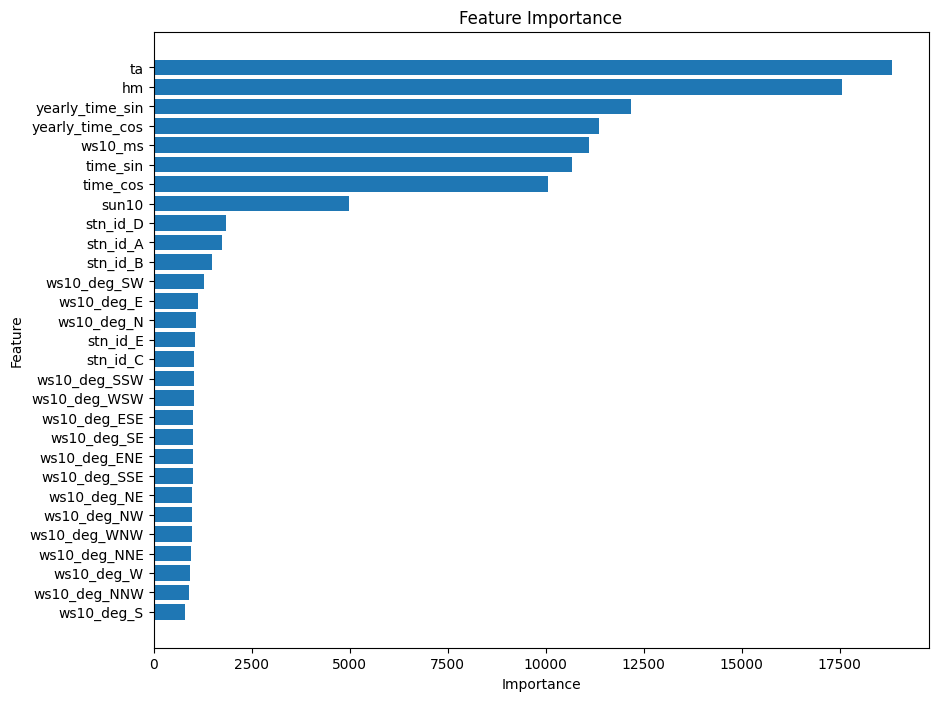

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Feature importance 추출
importance = bst.feature_importances_
feature_names = bst.booster_.feature_name()

# Feature importance를 데이터프레임으로 정리
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Feature importance 출력
print(feature_importance_df)

# Feature importance 시각화
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import shap

# SHAP explainer 생성
explainer = shap.Explainer(bst)

# SHAP 값을 계산
shap_values = explainer.shap_values(interpolated_test_data_t_drop)

# 특정 변수에 대한 SHAP 값을 시각화
variable_name = ['ta, hm']  # 알고 싶은 변수명으로 변경

# SHAP dependence plot
shap.dependence_plot(variable_name, shap_values, interpolated_test_data_t_drop, feature_names=bst.booster_.feature_name())


#XGBOOST

In [ ]:
train_df_A3_train = train_df_A3_train.drop('stn_id', axis=1)
train_df_A3_val = train_df_A3_val.drop('stn_id', axis=1)

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# 특징과 라벨 분리 (훈련 데이터)
X_train_final = train_df_A3_train.drop(['class', 'vis1'], axis=1)
y_train_final = train_df_A3_train['class']

X_val = train_df_A3_val.drop(['class', 'vis1'], axis=1)
y_val = train_df_A3_val['class']


In [ ]:
# 클래스 라벨을 0부터 시작하도록 변환 (라벨 값이 1부터 시작하는 경우)
y_train_final = y_train_final - y_train_final.min()
y_val = y_val - y_val.min()

# 라벨 값이 0부터 num_class-1 사이에 있는지 확인
assert y_train_final.min() >= 0 and y_train_final.max() < 4, "Train labels must be in the range [0, num_class)."
assert y_val.min() >= 0 and y_val.max() < 4, "Validation labels must be in the range [0, num_class)."

In [ ]:


# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_final), y=y_train_final)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train_final), class_weights)}

# 가중치 부여
weights = np.array([class_weights[label] for label in y_train_final])

# DMatrix 생성
dtrain = xgb.DMatrix(X_train_final, label=y_train_final, weight=weights)
dval = xgb.DMatrix(X_val, label=y_val)


In [ ]:

# XGBoost 모델 학습
param = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'eta': 0.3,
    'max_depth': 6,
    'seed': 42
}

num_round = 1000
evallist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

# 검증 데이터에 대한 예측
y_val_pred = bst.predict(dval)



[0]	eval-mlogloss:1.06002	train-mlogloss:1.23465
[1]	eval-mlogloss:0.87951	train-mlogloss:1.14439
[2]	eval-mlogloss:0.76131	train-mlogloss:1.08216
[3]	eval-mlogloss:0.68192	train-mlogloss:1.03701
[4]	eval-mlogloss:0.62352	train-mlogloss:1.00045
[5]	eval-mlogloss:0.58181	train-mlogloss:0.97287
[6]	eval-mlogloss:0.55453	train-mlogloss:0.95013
[7]	eval-mlogloss:0.53395	train-mlogloss:0.93199
[8]	eval-mlogloss:0.51984	train-mlogloss:0.91652
[9]	eval-mlogloss:0.50849	train-mlogloss:0.90370
[10]	eval-mlogloss:0.50032	train-mlogloss:0.89175
[11]	eval-mlogloss:0.49153	train-mlogloss:0.88199
[12]	eval-mlogloss:0.48217	train-mlogloss:0.87109
[13]	eval-mlogloss:0.47454	train-mlogloss:0.86452
[14]	eval-mlogloss:0.47118	train-mlogloss:0.85737
[15]	eval-mlogloss:0.46502	train-mlogloss:0.85127
[16]	eval-mlogloss:0.46287	train-mlogloss:0.84498
[17]	eval-mlogloss:0.46050	train-mlogloss:0.84043
[18]	eval-mlogloss:0.45590	train-mlogloss:0.83204
[19]	eval-mlogloss:0.45262	train-mlogloss:0.82698
[20]	eval-

In [ ]:
# 최종 평가
y_val = y_val + 1
y_val_pred = y_val_pred + 1


In [ ]:
# 혼동 행렬 계산
cm_val = confusion_matrix(y_val, y_val_pred, labels=[1, 2, 3, 4])


# 혼동 행렬 출력
print("Confusion Matrix for Validation Data:")
print(cm_val)


# 검증 데이터의 다중 CSI 계산
H_val = cm_val[0, 0] + cm_val[1, 1] + cm_val[2, 2]  # H11, H22, H33
F_val = (cm_val[0, 1] + cm_val[0, 2] + cm_val[1, 0] +
         cm_val[1, 2] + cm_val[2, 0] + cm_val[2, 1] +
         cm_val[3, 0] + cm_val[3, 1] + cm_val[3, 2])  # F12, F13, F21, F23, F31, F32, F41, F42, F43
M_val = cm_val[0, 3] + cm_val[1, 3] + cm_val[2, 3]  # M14, M24, M34

CSI_val = H_val / (H_val + F_val + M_val)
print(f"CSI for Validation Data: {CSI_val:.2f}")


Confusion Matrix for Validation Data:
[[   183    261    144    658]
 [   127    349    298    865]
 [    66    151    360   1225]
 [   615   2152   4303 461532]]
CSI for Validation Data: 0.08


In [ ]:
# 특징과 라벨 분리
X = interpolated_train_data_t_drop_encoded.drop(['class','vis1'], axis=1)
y = interpolated_train_data_t_drop_encoded['class']

# 오버샘플링 적용 전 클래스 비율 확인
print("Original class distribution:")
print(y.value_counts(normalize=True))

# 각 클래스의 샘플 개수 확인
class_counts = y.value_counts()

# 샘플링 전략 설정
sampling_strategy = {
    1: int(class_counts[1] * 18.0),  # 클래스 1의 목표 샘플 수
    2: int(class_counts[2] * 18.0),  # 클래스 2의 목표 샘플 수
    3: int(class_counts[3] * 18.0),  # 클래스 3의 목표 샘플 수
    4: class_counts[4]  # 클래스 4는 원래 개수 유지
}

# 오버샘플링 적용
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 오버샘플링 적용 후 클래스 비율 확인
print("Class distribution after SMOTE:")
print(pd.Series(y_res).value_counts(normalize=True))

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.25, random_state=42)

Original class distribution:
class
4.0    0.989769
3.0    0.003880
2.0    0.003847
1.0    0.002504
Name: proportion, dtype: float64
Class distribution after SMOTE:
class
4.0    0.843125
3.0    0.059492
2.0    0.058987
1.0    0.038395
Name: proportion, dtype: float64


In [ ]:
# 클래스 라벨을 0부터 시작하도록 변환
y_train -= 1
y_val -= 1

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# 가중치 부여
weights = np.array([class_weights[label] for label in y_train])

# DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
dval = xgb.DMatrix(X_val, label=y_val)

# XGBoost 모델 학습
param = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'eta': 0.3,
    'max_depth': 6,
    'seed': 42
}

num_round = 1000
evallist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

# 예측
y_pred = bst.predict(dval)

# 클래스 라벨을 원래대로 복원
y_val += 1
y_pred += 1

# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_pred, labels=[1, 2, 3, 4])

# 혼동 행렬 출력
print("Confusion Matrix:")
print(cm)

# 다중 CSI 계산
H = cm[0, 0] + cm[1, 1] + cm[2, 2]  # H11, H22, H33
F = (cm[0, 1] + cm[0, 2] + cm[1, 0] +
     cm[1, 2] + cm[2, 0] + cm[2, 1] +
     cm[3, 0] + cm[3, 1] + cm[3, 2]) # F12, F13, F21, F23, F31, F32, F41, F42, F43
M = cm[0, 3] + cm[1, 3] + cm[2, 3]  # M14, M24, M34

CSI = H / (H + F + M)
print(f"CSI: {CSI:.2f}")

KeyboardInterrupt: 

In [ ]:
# 클래스 라벨을 0부터 시작하도록 변환
y_train -= 1
y_val -= 1

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# 가중치 부여
weights = np.array([class_weights[label] for label in y_train])

# DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
dval = xgb.DMatrix(X_val, label=y_val)

# XGBoost 모델 학습
param = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'eta': 0.3,
    'max_depth': 6,
    'seed': 42
}

num_round = 1000
evallist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

# 예측
y_pred = bst.predict(dval)

# 클래스 라벨을 원래대로 복원
y_val += 1
y_pred += 1

# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_pred, labels=[1, 2, 3, 4])

# 혼동 행렬 출력
print("Confusion Matrix:")
print(cm)

# 다중 CSI 계산
H = cm[0, 0] + cm[1, 1] + cm[2, 2]  # H11, H22, H33
F = (cm[0, 1] + cm[0, 2] + cm[1, 0] +
     cm[1, 2] + cm[2, 0] + cm[2, 1] +
     cm[3, 0] + cm[3, 1] + cm[3, 2]) # F12, F13, F21, F23, F31, F32, F41, F42, F43
M = cm[0, 3] + cm[1, 3] + cm[2, 3]  # M14, M24, M34

CSI = H / (H + F + M)
print(f"CSI: {CSI:.2f}")

In [ ]:
bst

In [ ]:
#  Time에따라 다를듯 Minute 은 영향은 있겠지만 과연 유의미할까
# re가 왜 필요한건지?... 강수 전에 안개가 많지 않을까. 강수시에는 안개가 많다. 강수 직후에는 안개가 없지 않을까
# 전날 일사량이 많으면 안개가 많을것같다
# 풍속이 크면 안개가 없을것이다.
# 풍향이 과연 관련이 있을까? 지역에따라 풍향이 다를텐데? 동
# 지역별로 안개의 종류가 다르다고 한다 pdf의 개념을 적용시키고 새로운 변수를 만ㄴ들어보자!
# 변화량변수 그라디언트를 만들어보자
# 일교차 크면 당연히 많이 발생 그러나 데이터가 반영 안할듯 시계열로?...

Feature Importance:
                               Feature  Importance
2                                   ta     19217.0
0                             ws10_deg     18767.0
10                           Temp_Diff     17287.0
8                      yearly_time_sin     15743.0
17    sqrt_rounded_diff_rolling_std_3h     14596.0
6                             time_sin     14540.0
7                             time_cos     14233.0
9                      yearly_time_cos     13973.0
1                              ws10_ms     13103.0
16    sqrt_rounded_diff_rolling_std_1h      9773.0
4                                   hm      9225.0
14   sqrt_rounded_diff_rolling_mean_3h      9000.0
21            sqrt_rounded_diff_lag_18      7112.0
15   sqrt_rounded_diff_rolling_std_30m      6374.0
13   sqrt_rounded_diff_rolling_mean_1h      4601.0
5                                sun10      4470.0
20             sqrt_rounded_diff_lag_6      3727.0
12  sqrt_rounded_diff_rolling_mean_30m      3084.0
19         

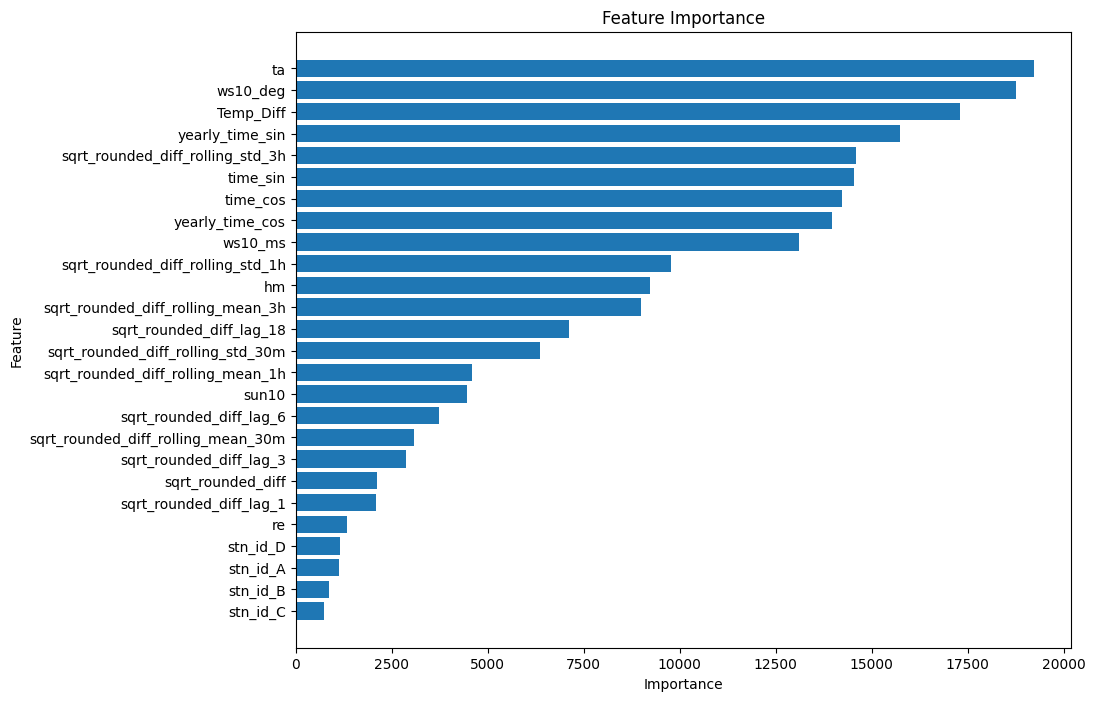

In [ ]:
# Feature importance 구하기
importance = bst.get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])

# 중요도 내림차순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# feature importance 출력
print("Feature Importance:")
print(importance_df)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
# 각 컬럼에 의미를 부여...
# 풀어쓰기
# shap로 선 부넉 후 도메인 적용

In [ ]:
# 테스트 데이터 예측
dtest = xgb.DMatrix(test_data_final_encoded)
y_test_pred = bst.predict(dtest)



In [ ]:
# y_test_pred 값별 비율 계산
unique, counts = np.unique(y_test_pred, return_counts=True)
ratios = counts / counts.sum()

# 값과 비율 출력
for value, ratio in zip(unique, ratios):
    print(f"Value: {value}, Ratio: {ratio:.9f}")

Value: 0.0, Ratio: 0.002279300
Value: 1.0, Ratio: 0.010422374
Value: 2.0, Ratio: 0.011662861
Value: 3.0, Ratio: 0.975635464


In [ ]:

# 예측 결과를 원래 클래스 라벨로 변환
y_test_pred = y_test_pred.astype(int) + 1

# 제출하기 위해 test데이터 다시 불러옴
sub_test_data = pd.read_csv('/content/drive/MyDrive/날씨 콘테스트/fog_test.csv')
sub_test_data = sub_test_data.drop(columns=['fog_test.class'], errors='ignore')

# 예측 결과를 데이터프레임으로 저장
sub_test_data['fog_test.class'] = y_test_pred

# 예측 결과 저장
sub_test_data.to_csv('240184.csv', index=False)
sub_test_data["fog_test.class"].value_counts()

fog_test.class
4    256397
3      3065
2      2739
1       599
Name: count, dtype: int64

In [ ]:
# 파일 다운로드
from google.colab import files
files.download('240184.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>